# Imports

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from torch import optim
import torch.nn as nn


# ---
import sys; sys.path.append('../')

from commons.imgs_mean_std import *

from commons.dataset import *
from commons.imageutils import *
from commons.HistCollection import *

from modules.img_transforms import *
from modules.train_functions import *
from modules.Comparator import *

from modules.Dataset import *
from modules.EarlyStopper import *

from modules.Model import *

# Constants & hyperparams

In [2]:
RANDOM_STATE=None

IMAGE_SIZE=220

BATCH_SIZE=32
NUM_EPOCHS=100

LEARNING_RATE=.001
MOMENTUM=.95

EARLY_PATIENCE=20
SCHEDULER_PATIENCE=10

# CUDA

In [3]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if device == 'cuda':
    print(torch.cuda.is_available())
    print(torch.cuda.get_device_name(0))
    print('Devices:', torch.cuda.device_count())

2.5.1+cu124
Device: cuda


# Loading datasets

In [4]:
train_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'train_dataset.csv'))
val_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'val_dataset.csv'))
test_dataset = pd.read_csv(os.path.join(DATASETS_PATHS.norm_faces.info, 'test_dataset.csv'))

# Creating custom datasets

In [5]:
normalization= normalize(IMAGE_SIZE, MEAN, STD)

train_dataset = CD_TrippletsCreator(train_dataset, transform=normalization, data_augmentation_tranforms=[data_augmentation()])
val_dataset = CD_TrippletsCreator(val_dataset, transform=normalization)
test_dataset = CD_TrippletsCreator(test_dataset, transform=normalization)

# Dataloaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=True)

# Early stopping

In [7]:
def early_callback(**kwarks):
    print(" > Early Stop <")

early_stopper = EarlyStopper(EARLY_PATIENCE, .001, callback=early_callback, verbose=True)

# Loading model

In [8]:
model = Model()
if device == 'cuda' and torch.cuda.device_count() > 1: model = nn.DataParallel(model)

model.to(device)

Model(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runn

# Defining tools

In [9]:
criterion = nn.TripletMarginWithDistanceLoss(distance_function=dst).to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=SCHEDULER_PATIENCE, verbose=True)

c:\Users\nelso\miniconda3\envs\vc_project\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training

In [10]:
def callback(**kwargs):
	print(f"Epoch: {kwargs['epoch']} =================================")
	print(f"\ttrain_loss: {kwargs['train_loss']:2f}\tval_loss: {kwargs['val_loss']:2f}")
	print(f"\tdst_mean_train (pos, neg): ({np.mean(kwargs['train_h'].posit_dst[-1]):2f}, {np.mean(kwargs['train_h'].negat_dst[-1]):2f}) dst_mean_val (pos, neg): ({np.mean(kwargs['val_h'].posit_dst[-1]):2f}, {np.mean(kwargs['val_h'].negat_dst[-1]):2f})")


train_h, val_h = train_loop(model, train_loader, val_loader=val_loader,
                            optimizer=optimizer, criterion=criterion, dst=dst, num_epoch=100, device=device,
                            early_stopper=early_stopper, scheduler=scheduler, callback=callback)

model.load_state_dict(early_stopper.best_model)

Epoch: 1 =================================
	train_loss: 1.013602	val_loss: 0.752264
	dst_mean_train (pos, neg): (3.364281, 3.363387) dst_mean_val (pos, neg): (0.789065, 1.060162)
Best model currently!!


Epoch: 2 =================================
	train_loss: 1.015616	val_loss: 0.830301
	dst_mean_train (pos, neg): (5.054722, 5.076863) dst_mean_val (pos, neg): (0.846215, 1.025127)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 3 =================================
	train_loss: 1.045467	val_loss: 0.753334
	dst_mean_train (pos, neg): (6.672013, 6.678567) dst_mean_val (pos, neg): (0.871083, 1.163614)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 4 =================================
	train_loss: 1.076951	val_loss: 0.841367
	dst_mean_train (pos, neg): (7.840614, 7.867929) dst_mean_val (pos, neg): (0.950179, 1.120862)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 5 =================================
	train_loss: 1.095101	val_loss: 0.883334
	dst_mean_train (pos, neg): (8.224687, 8.231008) dst_mean_val (pos, neg): (0.916269, 1.046510)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 6 =================================
	train_loss: 1.099817	val_loss: 0.910354
	dst_mean_train (pos, neg): (7.997890, 7.997829) dst_mean_val (pos, neg): (0.980689, 1.094644)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 7 =================================
	train_loss: 1.097535	val_loss: 0.816807
	dst_mean_train (pos, neg): (7.474183, 7.452523) dst_mean_val (pos, neg): (1.224313, 1.562786)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 8 =================================
	train_loss: 1.089965	val_loss: 0.819904
	dst_mean_train (pos, neg): (6.776738, 6.761163) dst_mean_val (pos, neg): (1.189316, 1.554755)
BEST: epoch: 1  val_loss: 0.7522640228271484


Epoch: 9 =================================
	train_loss: 1.025708	val_loss: 0.743780
	dst_mean_train (pos, neg): (6.388797, 6.463952) dst_mean_val (pos, neg): (1.527443, 2.229548)
Best model currently!!


Epoch: 10 =================================
	train_loss: 0.933613	val_loss: 0.896542
	dst_mean_train (pos, neg): (5.903283, 6.150704) dst_mean_val (pos, neg): (1.605208, 2.220389)
BEST: epoch: 9  val_loss: 0.743779718875885


Epoch: 11 =================================
	train_loss: 0.950010	val_loss: 0.719340
	dst_mean_train (pos, neg): (5.327769, 5.565636) dst_mean_val (pos, neg): (1.808022, 2.926498)
Best model currently!!


Epoch: 12 =================================
	train_loss: 0.863210	val_loss: 0.617218
	dst_mean_train (pos, neg): (4.815848, 5.254664) dst_mean_val (pos, neg): (1.360357, 2.485552)
Best model currently!!


Epoch: 13 =================================
	train_loss: 0.875353	val_loss: 0.612412
	dst_mean_train (pos, neg): (4.267977, 4.660540) dst_mean_val (pos, neg): (1.167859, 2.142576)
Best model currently!!


Epoch: 14 =================================
	train_loss: 0.837485	val_loss: 0.934497
	dst_mean_train (pos, neg): (4.083639, 4.541067) dst_mean_val (pos, neg): (1.485828, 2.212384)
BEST: epoch: 13  val_loss: 0.6124121844768524


Epoch: 15 =================================
	train_loss: 0.899235	val_loss: 0.670433
	dst_mean_train (pos, neg): (3.977483, 4.236408) dst_mean_val (pos, neg): (1.265595, 2.172962)
BEST: epoch: 13  val_loss: 0.6124121844768524


Epoch: 16 =================================
	train_loss: 0.860228	val_loss: 0.915813
	dst_mean_train (pos, neg): (4.017135, 4.435480) dst_mean_val (pos, neg): (1.675805, 2.781354)
BEST: epoch: 13  val_loss: 0.6124121844768524


Epoch: 17 =================================
	train_loss: 0.796960	val_loss: 0.652820
	dst_mean_train (pos, neg): (4.103519, 4.605950) dst_mean_val (pos, neg): (1.378619, 2.659736)
BEST: epoch: 13  val_loss: 0.6124121844768524


Epoch: 18 =================================
	train_loss: 0.764424	val_loss: 0.858229
	dst_mean_train (pos, neg): (4.176331, 4.738092) dst_mean_val (pos, neg): (1.750496, 3.057057)
BEST: epoch: 13  val_loss: 0.6124121844768524


Epoch: 19 =================================
	train_loss: 0.782212	val_loss: 0.512055
	dst_mean_train (pos, neg): (4.155414, 4.859469) dst_mean_val (pos, neg): (1.346824, 3.410474)
Best model currently!!


Epoch: 20 =================================
	train_loss: 0.761085	val_loss: 0.586440
	dst_mean_train (pos, neg): (3.953344, 4.538710) dst_mean_val (pos, neg): (1.252648, 2.691224)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 21 =================================
	train_loss: 0.767014	val_loss: 0.650762
	dst_mean_train (pos, neg): (3.931656, 4.465428) dst_mean_val (pos, neg): (1.425665, 2.980942)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 22 =================================
	train_loss: 0.734801	val_loss: 0.842093
	dst_mean_train (pos, neg): (4.132326, 4.853312) dst_mean_val (pos, neg): (1.685843, 2.982730)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 23 =================================
	train_loss: 0.687561	val_loss: 0.579916
	dst_mean_train (pos, neg): (4.110069, 5.107307) dst_mean_val (pos, neg): (1.604046, 3.614055)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 24 =================================
	train_loss: 0.790986	val_loss: 0.727307
	dst_mean_train (pos, neg): (3.683100, 4.357414) dst_mean_val (pos, neg): (1.105854, 1.865406)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 25 =================================
	train_loss: 0.801183	val_loss: 0.561006
	dst_mean_train (pos, neg): (3.299555, 3.722628) dst_mean_val (pos, neg): (1.245772, 3.070574)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 26 =================================
	train_loss: 0.703376	val_loss: 0.731910
	dst_mean_train (pos, neg): (3.268755, 3.962524) dst_mean_val (pos, neg): (1.223982, 2.327335)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 27 =================================
	train_loss: 0.658305	val_loss: 0.652270
	dst_mean_train (pos, neg): (3.443795, 4.274210) dst_mean_val (pos, neg): (1.441993, 3.058826)
BEST: epoch: 19  val_loss: 0.512054905295372


Epoch: 28 =================================
	train_loss: 0.695568	val_loss: 0.465914
	dst_mean_train (pos, neg): (3.685911, 4.696671) dst_mean_val (pos, neg): (1.032093, 2.400828)
Best model currently!!


Epoch: 29 =================================
	train_loss: 0.664482	val_loss: 0.398056
	dst_mean_train (pos, neg): (3.177121, 3.950590) dst_mean_val (pos, neg): (1.352763, 3.402434)
Best model currently!!


Epoch: 30 =================================
	train_loss: 0.653419	val_loss: 0.889467
	dst_mean_train (pos, neg): (3.492187, 4.576120) dst_mean_val (pos, neg): (1.647782, 3.181958)
BEST: epoch: 29  val_loss: 0.3980562835931778


Epoch: 31 =================================
	train_loss: 0.692371	val_loss: 0.521461
	dst_mean_train (pos, neg): (3.445601, 4.359832) dst_mean_val (pos, neg): (1.311924, 2.888736)
BEST: epoch: 29  val_loss: 0.3980562835931778


Epoch: 32 =================================
	train_loss: 0.655728	val_loss: 0.504580
	dst_mean_train (pos, neg): (3.206241, 4.196781) dst_mean_val (pos, neg): (1.257861, 3.088694)
BEST: epoch: 29  val_loss: 0.3980562835931778


Epoch: 33 =================================
	train_loss: 0.663403	val_loss: 0.660031
	dst_mean_train (pos, neg): (3.321273, 4.537484) dst_mean_val (pos, neg): (1.367695, 3.038878)
BEST: epoch: 29  val_loss: 0.3980562835931778


Epoch: 34 =================================
	train_loss: 0.631337	val_loss: 0.389826
	dst_mean_train (pos, neg): (3.222140, 4.207847) dst_mean_val (pos, neg): (1.182073, 2.971149)
Best model currently!!


Epoch: 35 =================================
	train_loss: 0.626187	val_loss: 0.655648
	dst_mean_train (pos, neg): (3.481185, 4.800933) dst_mean_val (pos, neg): (1.578236, 4.119233)
BEST: epoch: 34  val_loss: 0.38982634246349335


Epoch: 36 =================================
	train_loss: 0.627064	val_loss: 0.822778
	dst_mean_train (pos, neg): (3.297458, 4.438561) dst_mean_val (pos, neg): (1.339097, 2.283993)
BEST: epoch: 34  val_loss: 0.38982634246349335


Epoch: 37 =================================
	train_loss: 0.671413	val_loss: 0.424090
	dst_mean_train (pos, neg): (3.005336, 3.895169) dst_mean_val (pos, neg): (1.191605, 3.141261)
BEST: epoch: 34  val_loss: 0.38982634246349335


Epoch: 38 =================================
	train_loss: 0.621987	val_loss: 0.565971
	dst_mean_train (pos, neg): (3.088229, 4.082535) dst_mean_val (pos, neg): (1.330196, 2.986929)
BEST: epoch: 34  val_loss: 0.38982634246349335


Epoch: 39 =================================
	train_loss: 0.569562	val_loss: 0.636186
	dst_mean_train (pos, neg): (3.268789, 4.479163) dst_mean_val (pos, neg): (1.399226, 3.357857)
BEST: epoch: 34  val_loss: 0.38982634246349335


Epoch: 40 =================================
	train_loss: 0.588558	val_loss: 0.333680
	dst_mean_train (pos, neg): (3.486029, 4.799475) dst_mean_val (pos, neg): (1.044412, 3.043857)
Best model currently!!


Epoch: 41 =================================
	train_loss: 0.554007	val_loss: 0.436659
	dst_mean_train (pos, neg): (3.396436, 4.664231) dst_mean_val (pos, neg): (1.473297, 4.085966)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 42 =================================
	train_loss: 0.540646	val_loss: 0.637949
	dst_mean_train (pos, neg): (3.373789, 5.074853) dst_mean_val (pos, neg): (1.443833, 3.483771)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 43 =================================
	train_loss: 0.603681	val_loss: 0.477411
	dst_mean_train (pos, neg): (3.293782, 4.694664) dst_mean_val (pos, neg): (1.187903, 2.877268)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 44 =================================
	train_loss: 0.603699	val_loss: 0.531038
	dst_mean_train (pos, neg): (3.098183, 4.126323) dst_mean_val (pos, neg): (1.286402, 2.725293)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 45 =================================
	train_loss: 0.523132	val_loss: 0.511395
	dst_mean_train (pos, neg): (3.237270, 4.802162) dst_mean_val (pos, neg): (1.749826, 3.898874)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 46 =================================
	train_loss: 0.518550	val_loss: 0.702626
	dst_mean_train (pos, neg): (3.459870, 5.324808) dst_mean_val (pos, neg): (1.636842, 3.622685)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 47 =================================
	train_loss: 0.529163	val_loss: 0.597324
	dst_mean_train (pos, neg): (3.476087, 5.300869) dst_mean_val (pos, neg): (1.818589, 4.459454)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 48 =================================
	train_loss: 0.603619	val_loss: 0.519358
	dst_mean_train (pos, neg): (3.450639, 5.096040) dst_mean_val (pos, neg): (1.453732, 3.636833)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 49 =================================
	train_loss: 0.507560	val_loss: 0.564666
	dst_mean_train (pos, neg): (3.145840, 4.638099) dst_mean_val (pos, neg): (1.682556, 3.914726)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 50 =================================
	train_loss: 0.513225	val_loss: 0.659088
	dst_mean_train (pos, neg): (3.387949, 5.200110) dst_mean_val (pos, neg): (1.741343, 3.899593)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 51 =================================
	train_loss: 0.564796	val_loss: 0.441188
	dst_mean_train (pos, neg): (3.462051, 5.417301) dst_mean_val (pos, neg): (1.712755, 4.472212)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 52 =================================
	train_loss: 0.525429	val_loss: 0.709839
	dst_mean_train (pos, neg): (3.274118, 5.106845) dst_mean_val (pos, neg): (1.648165, 3.661402)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 53 =================================
	train_loss: 0.517307	val_loss: 0.417223
	dst_mean_train (pos, neg): (3.259695, 5.091151) dst_mean_val (pos, neg): (1.479639, 4.074041)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 54 =================================
	train_loss: 0.488808	val_loss: 0.617826
	dst_mean_train (pos, neg): (3.161941, 4.974165) dst_mean_val (pos, neg): (1.493952, 3.143733)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 55 =================================
	train_loss: 0.466083	val_loss: 0.462843
	dst_mean_train (pos, neg): (3.031279, 4.781965) dst_mean_val (pos, neg): (1.583695, 4.063808)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 56 =================================
	train_loss: 0.438688	val_loss: 0.540043
	dst_mean_train (pos, neg): (3.018692, 4.814064) dst_mean_val (pos, neg): (1.574848, 4.149562)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 57 =================================
	train_loss: 0.432518	val_loss: 0.418870
	dst_mean_train (pos, neg): (2.983495, 4.764641) dst_mean_val (pos, neg): (1.436941, 3.598290)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 58 =================================
	train_loss: 0.395879	val_loss: 0.488392
	dst_mean_train (pos, neg): (2.894479, 4.784425) dst_mean_val (pos, neg): (1.401046, 3.698736)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 59 =================================
	train_loss: 0.438316	val_loss: 0.387776
	dst_mean_train (pos, neg): (2.998237, 4.897293) dst_mean_val (pos, neg): (1.383098, 3.749230)
BEST: epoch: 40  val_loss: 0.33368049561977386
 > Early Stop <


<All keys matched successfully>

In [11]:
save_model(model, 'model.pth', complete=False)

# Model evaluation

In [12]:
def train_val_analisys(**kwargs):

	train_posit_mean_h = [np.mean(elm) for elm in  kwargs['train_h'].posit_dst]
	train_negat_mean_h = [np.mean(elm) for elm in  kwargs['train_h'].negat_dst]

	train_posit_median_h = [np.median(elm) for elm in kwargs['train_h'].posit_dst]
	train_negat_median_h = [np.median(elm) for elm in kwargs['train_h'].negat_dst]

	val_posit_mean_h = [np.mean(elm) for elm in  kwargs['val_h'].posit_dst]
	val_negat_mean_h = [np.mean(elm) for elm in  kwargs['val_h'].negat_dst]

	val_posit_median_h = [np.median(elm) for elm in kwargs['val_h'].posit_dst]
	val_negat_median_h = [np.median(elm) for elm in kwargs['val_h'].negat_dst]


	plt.figure(figsize=(24, 6))

	plt.subplot(1, 3, 1); plt.title('Train / Val loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.xticks([1, len(kwargs['val_h'].loss)])
	plt.plot(kwargs['train_h'].loss, label='Train')
	plt.plot(kwargs['val_h'].loss, label='Val')
	plt.plot(kwargs['best_loss'][0]-1, kwargs['best_loss'][1], 'o', )
	plt.annotate('best', (kwargs['best_loss'][0]-1, kwargs['best_loss'][1]))
	plt.axvline(kwargs['best_loss'][0]-1, linestyle='dashed', color='red', linewidth=1)
	plt.legend()

	plt.subplot(1, 3, 2); plt.title('Distances means')
	plt.xlabel('Epochs')
	plt.ylabel('Mean')
	plt.xticks([1, len(kwargs['val_h'].loss)])
	plt.plot(train_posit_mean_h, label='Train positive')
	plt.plot(train_negat_mean_h, label='Train negative')
	plt.plot(val_posit_mean_h, label='Val positive')
	plt.plot(val_negat_mean_h, label='Val negative')
	plt.axvline(kwargs['best_loss'][0]-1, linestyle='dashed', color='red', linewidth=1)
	plt.legend()

	plt.subplot(1,3,3); plt.title('Distances medians')
	plt.xlabel('Epoch')
	plt.ylabel('Median')
	plt.xticks([1, len(kwargs['val_h'].loss)])
	plt.plot(train_posit_median_h, label='Train positive')
	plt.plot(train_negat_median_h, label='Train negative')
	plt.plot(val_posit_median_h, label='Val positive')
	plt.plot(val_negat_median_h, label='Val negative')
	plt.axvline(kwargs['best_loss'][0]-1, linestyle='dashed', color='red', linewidth=1)
	plt.legend()


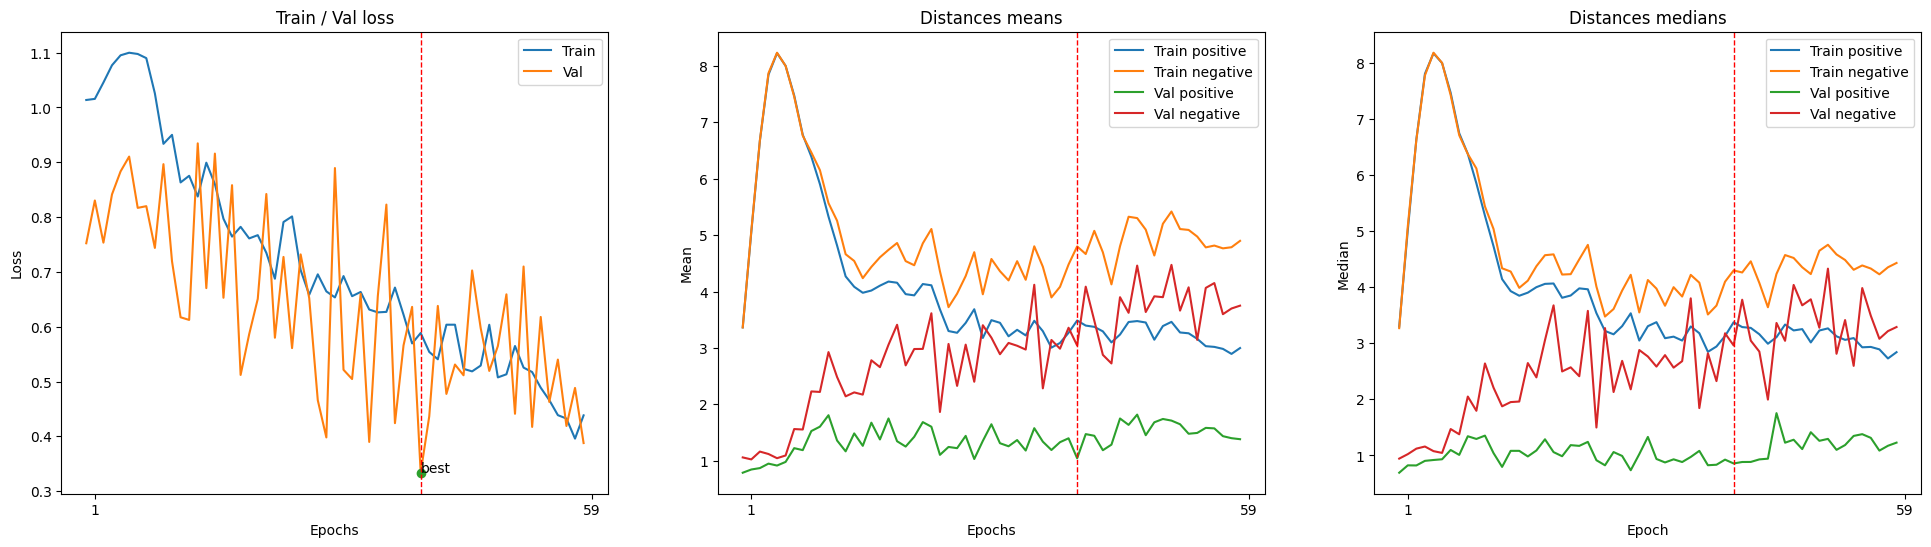

In [13]:
train_val_analisys(train_h=train_h, val_h=val_h, best_loss=(early_stopper.best_epoch, early_stopper.best_loss))

# Test

In [14]:
test_h = eval(model, test_loader, device=device, criterion=criterion, dst=dst)
print('Loss', test_h.loss)
print(f'Posit dst:\t| mean {np.mean(test_h.posit_dst)}\t| median {np.median(test_h.posit_dst)}\t| std {np.std(test_h.posit_dst)}\t| min, max {np.min(test_h.posit_dst)}, {np.max(test_h.posit_dst)}\t| diff(min,max) {np.max(test_h.posit_dst)-np.min(test_h.posit_dst)}')
print(f'Negat dst:\t| mean {np.mean(test_h.negat_dst)}\t| median {np.median(test_h.negat_dst)}\t| std {np.std(test_h.negat_dst)}\t| min, max {np.min(test_h.negat_dst)}, {np.max(test_h.negat_dst)}\t| diff(min,max) {np.max(test_h.negat_dst)-np.min(test_h.negat_dst)}')
print(f'Diff(max(posit_dst), min(negat_dst)) {min(test_h.negat_dst) - max(test_h.posit_dst)}')

Loss 0.4830780029296875
Posit dst:	| mean 1.473170286975801	| median 1.2176315784454346	| std 0.9215030930127397	| min, max 0.19301071763038635, 3.6138923168182373	| diff(min,max) 3.420881599187851
Negat dst:	| mean 3.4036544831469655	| median 3.031758427619934	| std 2.1668109497348556	| min, max 0.455168753862381, 8.081620216369629	| diff(min,max) 7.626451462507248
Diff(max(posit_dst), min(negat_dst)) -3.1587235629558563


# Segundo entrenamiento con el mejor modelo actual

In [15]:
train_h_, val_h_ =  train_h.copy(), val_h.copy()
train_h_.loss, val_h_.loss = train_h_.loss[:early_stopper.best_epoch], val_h_.loss[:early_stopper.best_epoch]
train_h_.posit_dst, val_h_.posit_dst  = train_h_.posit_dst[:early_stopper.best_epoch], val_h_.posit_dst[:early_stopper.best_epoch]
train_h_.negat_dst, val_h_.negat_dst  = train_h_.negat_dst[:early_stopper.best_epoch], val_h_.negat_dst[:early_stopper.best_epoch]
train_h_.asetid, val_h_.asetid  = train_h_.asetid[:early_stopper.best_epoch], val_h_.asetid[:early_stopper.best_epoch]
train_h_.nsetid, val_h_.nsetid = train_h_.nsetid[:early_stopper.best_epoch], val_h_.nsetid[:early_stopper.best_epoch]

In [16]:
early_stopper.reset()

train_h_, val_h_ = train_loop(model, train_loader, val_loader=val_loader, initial_epoch=early_stopper.best_epoch,
                            optimizer=optimizer, criterion=criterion, dst=dst, num_epoch=100, device=device,
                            early_stopper=early_stopper, scheduler=scheduler, callback=callback, train_h=train_h_, val_h=val_h_)

model.load_state_dict(early_stopper.best_model)
save_model(model, '../model.pth', complete=False)

Epoch: 41 =================================
	train_loss: 0.435748	val_loss: 0.530212
	dst_mean_train (pos, neg): (2.952116, 4.846661) dst_mean_val (pos, neg): (1.436714, 3.976194)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 42 =================================
	train_loss: 0.393043	val_loss: 0.537235
	dst_mean_train (pos, neg): (2.931338, 4.977153) dst_mean_val (pos, neg): (1.511986, 3.580752)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 43 =================================
	train_loss: 0.445737	val_loss: 0.578633
	dst_mean_train (pos, neg): (2.852978, 4.872901) dst_mean_val (pos, neg): (1.411169, 3.134242)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 44 =================================
	train_loss: 0.430402	val_loss: 0.357570
	dst_mean_train (pos, neg): (2.879779, 4.881278) dst_mean_val (pos, neg): (1.429542, 4.311941)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 45 =================================
	train_loss: 0.440044	val_loss: 0.415413
	dst_mean_train (pos, neg): (2.882976, 4.842021) dst_mean_val (pos, neg): (1.557329, 4.207845)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 46 =================================
	train_loss: 0.451140	val_loss: 0.487858
	dst_mean_train (pos, neg): (2.886475, 4.834175) dst_mean_val (pos, neg): (1.471210, 3.341973)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 47 =================================
	train_loss: 0.385565	val_loss: 0.444967
	dst_mean_train (pos, neg): (2.828573, 4.824950) dst_mean_val (pos, neg): (1.485745, 4.036787)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 48 =================================
	train_loss: 0.406880	val_loss: 0.347054
	dst_mean_train (pos, neg): (2.808360, 4.782791) dst_mean_val (pos, neg): (1.271087, 3.838519)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 49 =================================
	train_loss: 0.448267	val_loss: 0.557728
	dst_mean_train (pos, neg): (2.816850, 4.698351) dst_mean_val (pos, neg): (1.432162, 3.760295)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 50 =================================
	train_loss: 0.387268	val_loss: 0.421243
	dst_mean_train (pos, neg): (2.859849, 5.003903) dst_mean_val (pos, neg): (1.368102, 3.884713)
BEST: epoch: 40  val_loss: 0.33368049561977386


Epoch: 51 =================================
	train_loss: 0.438873	val_loss: 0.263894
	dst_mean_train (pos, neg): (2.897018, 4.814477) dst_mean_val (pos, neg): (1.373429, 3.842592)
Best model currently!!


Epoch: 52 =================================
	train_loss: 0.432654	val_loss: 0.504299
	dst_mean_train (pos, neg): (2.846238, 4.751383) dst_mean_val (pos, neg): (1.470125, 4.285317)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 53 =================================
	train_loss: 0.402181	val_loss: 0.605778
	dst_mean_train (pos, neg): (2.879091, 4.983633) dst_mean_val (pos, neg): (1.384010, 3.536983)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 54 =================================
	train_loss: 0.369854	val_loss: 0.408610
	dst_mean_train (pos, neg): (2.805553, 4.984230) dst_mean_val (pos, neg): (1.336652, 3.805528)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 55 =================================
	train_loss: 0.445728	val_loss: 0.510625
	dst_mean_train (pos, neg): (2.856388, 4.797142) dst_mean_val (pos, neg): (1.448890, 3.817690)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 56 =================================
	train_loss: 0.401618	val_loss: 0.545626
	dst_mean_train (pos, neg): (2.817171, 4.811703) dst_mean_val (pos, neg): (1.485613, 3.821318)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 57 =================================
	train_loss: 0.429978	val_loss: 0.285899
	dst_mean_train (pos, neg): (2.857720, 4.808129) dst_mean_val (pos, neg): (1.399412, 4.320310)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 58 =================================
	train_loss: 0.470936	val_loss: 0.510711
	dst_mean_train (pos, neg): (2.891804, 4.822917) dst_mean_val (pos, neg): (1.476288, 3.863991)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 59 =================================
	train_loss: 0.389325	val_loss: 0.434101
	dst_mean_train (pos, neg): (2.797491, 4.866694) dst_mean_val (pos, neg): (1.412419, 3.862204)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 60 =================================
	train_loss: 0.425170	val_loss: 0.397715
	dst_mean_train (pos, neg): (2.902724, 4.889394) dst_mean_val (pos, neg): (1.564741, 3.820143)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 61 =================================
	train_loss: 0.387194	val_loss: 0.437561
	dst_mean_train (pos, neg): (2.814052, 4.926132) dst_mean_val (pos, neg): (1.460095, 4.217496)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 62 =================================
	train_loss: 0.390052	val_loss: 0.615917
	dst_mean_train (pos, neg): (2.835376, 5.002058) dst_mean_val (pos, neg): (1.400242, 3.661683)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 63 =================================
	train_loss: 0.427652	val_loss: 0.587190
	dst_mean_train (pos, neg): (2.824381, 4.699085) dst_mean_val (pos, neg): (1.448700, 3.546468)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 64 =================================
	train_loss: 0.419648	val_loss: 0.395949
	dst_mean_train (pos, neg): (2.839749, 4.929548) dst_mean_val (pos, neg): (1.439951, 4.030252)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 65 =================================
	train_loss: 0.430913	val_loss: 0.267756
	dst_mean_train (pos, neg): (2.844457, 4.771992) dst_mean_val (pos, neg): (1.392928, 4.119346)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 66 =================================
	train_loss: 0.394800	val_loss: 0.675314
	dst_mean_train (pos, neg): (2.813926, 4.802176) dst_mean_val (pos, neg): (1.379970, 3.209843)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 67 =================================
	train_loss: 0.332656	val_loss: 0.418384
	dst_mean_train (pos, neg): (2.845800, 5.247133) dst_mean_val (pos, neg): (1.375437, 3.874283)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 68 =================================
	train_loss: 0.446580	val_loss: 0.489927
	dst_mean_train (pos, neg): (2.840832, 4.899394) dst_mean_val (pos, neg): (1.419004, 3.887953)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 69 =================================
	train_loss: 0.372177	val_loss: 0.527929
	dst_mean_train (pos, neg): (2.794452, 4.920269) dst_mean_val (pos, neg): (1.348833, 3.875358)
BEST: epoch: 51  val_loss: 0.2638936936855316


Epoch: 70 =================================
	train_loss: 0.400514	val_loss: 0.459874
	dst_mean_train (pos, neg): (2.845334, 4.933569) dst_mean_val (pos, neg): (1.416482, 3.659359)
BEST: epoch: 51  val_loss: 0.2638936936855316
 > Early Stop <


In [17]:
model.load_state_dict(early_stopper.best_model)
save_model(model, '../model.pth', complete=False)

# Analisys again

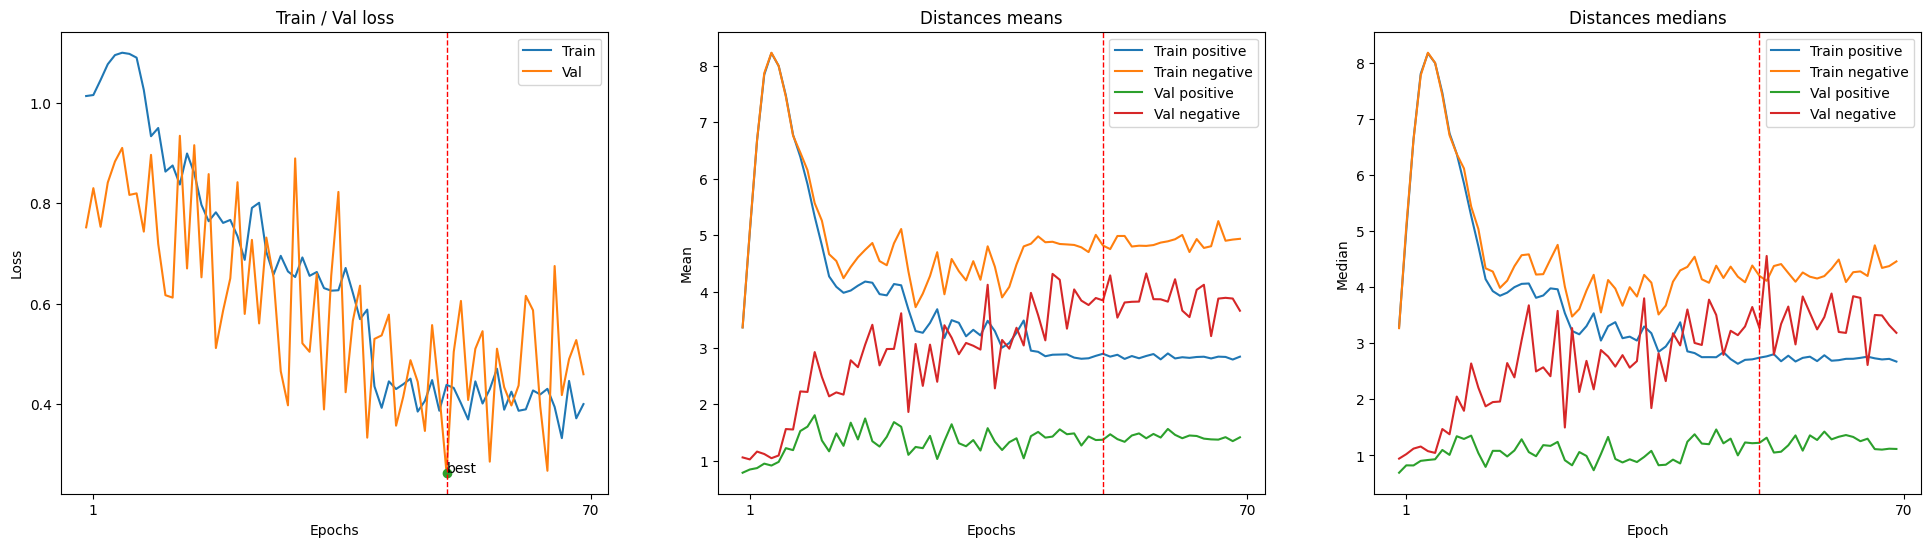

In [18]:
train_val_analisys(train_h=train_h_, val_h=val_h_, best_loss=(early_stopper.best_epoch, early_stopper.best_loss))

In [19]:
test_h = eval(model, test_loader, device=device, criterion=criterion, dst=dst)
print('Loss', test_h.loss)
print(f'Posit dst:\t| mean {np.mean(test_h.posit_dst)}\t| median {np.median(test_h.posit_dst)}\t| std {np.std(test_h.posit_dst)}\t| min, max {np.min(test_h.posit_dst)}, {np.max(test_h.posit_dst)}\t| diff(min,max) {np.max(test_h.posit_dst)-np.min(test_h.posit_dst)}')
print(f'Negat dst:\t| mean {np.mean(test_h.negat_dst)}\t| median {np.median(test_h.negat_dst)}\t| std {np.std(test_h.negat_dst)}\t| min, max {np.min(test_h.negat_dst)}, {np.max(test_h.negat_dst)}\t| diff(min,max) {np.max(test_h.negat_dst)-np.min(test_h.negat_dst)}')
print(f'Diff(max(posit_dst), min(negat_dst)) {min(test_h.negat_dst) - max(test_h.posit_dst)}')

Loss 0.36033838987350464
Posit dst:	| mean 1.4632612499408424	| median 1.1054602265357971	| std 0.8907289976563053	| min, max 0.2247583419084549, 3.42179274559021	| diff(min,max) 3.197034403681755
Negat dst:	| mean 3.663035959005356	| median 3.885785937309265	| std 2.255472419401447	| min, max 0.4521939754486084, 9.316268920898438	| diff(min,max) 8.864074945449829
Diff(max(posit_dst), min(negat_dst)) -2.9695987701416016
